In [4]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [247]:
from __future__ import print_function, division

import numpy as np
from scipy import interpolate

from astropy import units as u
from astropy import constants as cnst
from astropy import table
from astropy.stats import sigma_clip
from astropy import modeling

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)
plt.rcParams['image.cmap'] = 'viridis'

# Find all of the sats that are in SAGA hosts

In [46]:
t = table.Table.read('SAGADropbox/data/saga_spectra_clean.fits.gz')

In [126]:
t[(t['TELNAME']=='NSA')&(t['SATS']==1)]

OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,clean,SATURATED,BAD_COUNTS_ERROR,BINNED1,TOO_FEW_GOOD_DETECTIONS,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS,SPECOBJID,SPEC_REPEAT
int64,float64,float64,int16,str40,int64,int32,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str48,float64,float64,int64,int64,float64,float64,int64,str6,str48,int64,str2,str48,str48
1237648722289295527,145.320962664,0.771102651396,3,GALAXY,68988043776,1,0,0,268435456,0,18.7395,17.6063,17.1605,16.9516,16.7769,0.0283063,0.00646028,0.00594115,0.00720908,0.0171965,0.0273266,0.0062947,0.00570953,0.00689574,0.0178854,0.608006,0.447365,0.324466,0.246033,0.174441,18.2627,17.2831,16.9258,16.7912,16.6819,3.77931,4.4029,4.98527,5.1239,24.9092,0.217144,0.111835,0.141186,0.116695,8.51344,2.57427,0.425552,3.45923,0.0851165,4.06205,0.12706,4.24132,0.119345,5.17283,0.379126,0.670546,0.681586,0.688063,0.712973,0.707609,18.9483,0.0272871,17.6245,0.00638381,17.0989,0.00582051,16.8696,0.00705032,16.6378,0.0185209,20.0718,0.0352348,19.106,0.0140474,18.602,0.0193119,18.4885,0.0157263,18.4235,0.0277232,20.0572,0.0323801,18.96,0.00819829,18.549,0.00751242,18.3379,0.00918833,18.148,0.024217,0.251249,0.395446,0.344743,0.334241,0.323474,0.0608646,0.0327015,0.0777924,0.0654216,0.0742687,0.0610308,0.0632748,0.0512498,0.0413077,0.105914,0.71549,1.59726,14.1018,0.710982,1.90739,21.88,0.731562,2.04755,20.5199,0.758912,2.02837,20.178,0.737766,2.04899,30.4873,19.2578,0.010051,17.2503,0.00570953,2.23696,5.74052,17.1605,20.

In [45]:
sagamasks = ~((t['TELNAME']=='SDSS')|(t['TELNAME']=='NSA')|(t['TELNAME']=='GAMA'))
sagaids = np.unique(t['HOST_NSAID'][sagamasks])
sagaspectra = t[np.in1d(t['HOST_NSAID'], sagaids)]

sats = sagaspectra[sagaspectra['SATS']==1]
sats

OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,clean,SATURATED,BAD_COUNTS_ERROR,BINNED1,TOO_FEW_GOOD_DETECTIONS,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS,SPECOBJID,SPEC_REPEAT
int64,float64,float64,int16,str40,int64,int32,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str48,float64,float64,int64,int64,float64,float64,int64,str6,str48,int64,str2,str48,str48
1237651735757259099,180.636494306,1.95802947978,3,GALAXY,281543964623104,0,0,0,268435456,281474976710656,26.9357,19.2637,18.6728,18.9803,26.7732,3.48973,0.0899796,0.0839212,0.173803,0.658678,3.48973,0.0899796,0.0839212,0.173803,0.658678,0.115032,0.0846394,0.0613876,0.0465483,0.0330033,26.8206,19.1791,18.6114,18.9337,26.7402,2.97098,2.97006,258.374,2.96948,2.97022,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,2.12566,3.65126,29.6753,2.31745,27.1824,8.31657,29.6695,2.53441,0.00358716,27.1103,0.05,0.623367,0.999923,0.952344,0.0501283,21.8828,0.386924,19.1192,0.0916567,17.2244,0.0721443,18.0551,0.166074,22.1379,0.697607,22.5648,0.410591,22.7915,0.178714,22.782,0.271717,23.0981,0.472571,22.0059,0.635566,23.3443,0.69363,22.7732,0.188145,22.6497,0.264579,22.8432,0.479258,22.1462,0.862093,1.0,0.337854,0.301263,0.0654641,1.0,-0.191439,0.930425,-0.0791527,0.00684313,-0.136734,0.142043,0.126804,0.243481,-0.424756,-3.02252,0.05,3.41202,63.378,0.344957,17.0706,153.516,0.374638,57.5764,150.554,0.679342,24.642,146.598,0.300015,0.000382415,90.4881,23.3621,0.323969,16.9897,0.0668231,3.80096,5.55442,20.4335,27.7863323159,25.328416084

In [110]:
palomar_A = 1.76e5 * u.cm**2

In [301]:
# see the section at the bottom for how the relations were derived
u_fibmag_to_haflux = lambda mag: (10**(mag*-0.5447 - 3.4666))*u.erg/u.s * u.cm**-2
r_fibmag_to_haflux = lambda mag: (10**(mag*-0.5075 - 5.1159))*u.erg/u.s * u.cm**-2

u_haflux_sats = u_fibmag_to_haflux(sats['FIBERMAG_U'])
r_haflux_sats = r_fibmag_to_haflux(sats['FIBERMAG_R'])
haflux_sats = (u_haflux_sats + r_haflux_sats)/2

In [326]:
typical_ha_linewidth = 5*u.angstrom

# CWI

From Jeremy:

Since you have spectra already, this should be pretty straight-forward. I use 20 minute exposures. Sometimes I combine two 20 minute exposures. The staff recommends sticking to this observing strategy. For the 20 minute exposures, the typical noise per pixel in a given spaxel is about 7x10^-18 erg/s/cm^2 (+/- 1x10^-18 erg/s/cm^2). This is pretty consistent across the entire bandwidth and across the CCD. I have found you can measure line centers down to a S/N of 5. I have not done mosaics but I know others have. The spatial resolution is about 2.7" by whatever your seeing is. You can rotate the FOV 90 degrees and co-add to get seeing limited data but rotation is not a simple task. The FOV is 60" by 40" but the edges of the field are a little wonky. The nod-and-shuffle mask limits the bandwidth range but is fine for H-alpha and both NII lines.

In [338]:
cwi_noise_20min = 7e-18 * u.erg/u.s*u.cm**-2

fib_to_cwi_spaxel = 2.5/(np.pi*3**2)  # area of a spaxel vs. area of SDSS fiber

In [339]:
snr20min = haflux_sats*fib_to_cwi_spaxel/cwi_noise_20min
timeto5 = (snr20min/5)**-0.5 * 20*u.min

np.sum(timeto5).to(u.hour)

<Quantity 15.439402262369791 h>

# DBSpec 

Following http://www.astro.caltech.edu/~enk/dbsp_throughput/, but just assuming a straight ~20% throughput, which is good for ~Halpha for most gratings

As it currently stands this is wrong as it doesn't account for the sky background, but it also assumes the equivalent width is only ~5, so maybe those cancel...?

In [94]:
m_to_nphot(10, 1*u.second, 1*u.angstrom, 6563*u.angstrom)

<Quantity 2938.896338544408>

In [352]:
(0*u.ABmag).physical.to(u.erg*u.cm**-2)

<Quantity 3.630780547701003e-20 erg / cm2>

In [347]:
(cwi_noise_20min/(0*u.ABmag).physical/u.Hz).decompose()

<Quantity 192.7960092336722>

In [95]:
def m_to_nphot(mag, texp, dellamb, lamb, throughput=.2):
    num = texp * palomar_A * dellamb * (mag*u.ABmag).physical
    den = cnst.h * lamb
    return (throughput*num/den).decompose()
m_to_nphot(20, 1*u.second, 5*u.angstrom, 6563*u.angstrom)

<Quantity 0.2938896338544408>

In [104]:
# let's just say 2" is typical seeing
countrate = m_to_nphot(sats['FIBER2MAG_R'], 1*u.second, 1*u.angstrom, 6563*u.angstrom)/u.second

# assume we need ~100 counts per/angstrom for a decent centroid
time_needed = 100/ countrate
time_needed

<Quantity [ 7527.83544922,  666.25445557,  215.03125   ,  927.83422852,
             558.86645508, 3428.55908203, 5340.51513672, 1555.61242676,
             660.48156738, 2494.83325195,  969.76794434, 3791.83984375,
             201.49609375,  657.36633301,  642.84979248,   95.36885071,
             423.35195923,   10.65034103,  116.72737885, 5751.80273438,
             274.92242432,  232.68101501,  107.1593399 , 1261.27636719,
            3053.53857422,  435.76074219, 1490.84191895, 1600.18225098,
              69.73154449,  208.75578308,  882.53387451, 2814.62280273,
             244.51655579,  208.3495636 ,  178.21990967, 2607.64550781,
              28.30368614, 1373.1394043 ,  139.0375061 ,  112.83287048,
             992.73223877, 3507.2824707 , 1947.46643066,   49.37942886,
            1216.76098633, 1417.73278809,  236.72515869,  301.72753906,
             610.7119751 ] s>

In [106]:
np.sum(time_needed).to(u.hour)

<Quantity 17.678226996527776 h>

# Keck 

# Investigate H$\alpha$ vs. mags 

In [144]:
nsa = table.Table(hosts.get_nsa())

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/sa

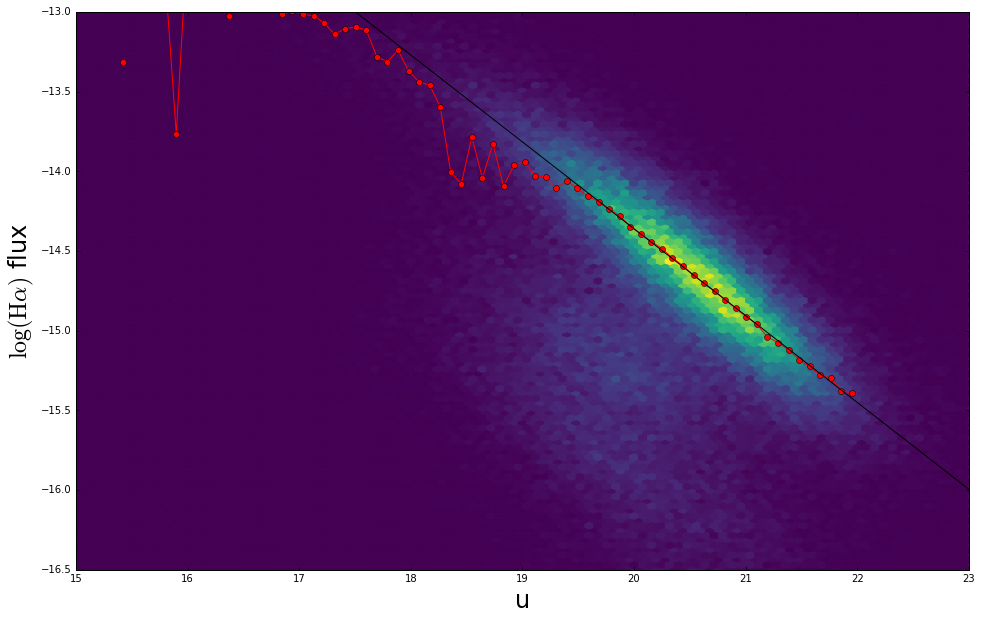

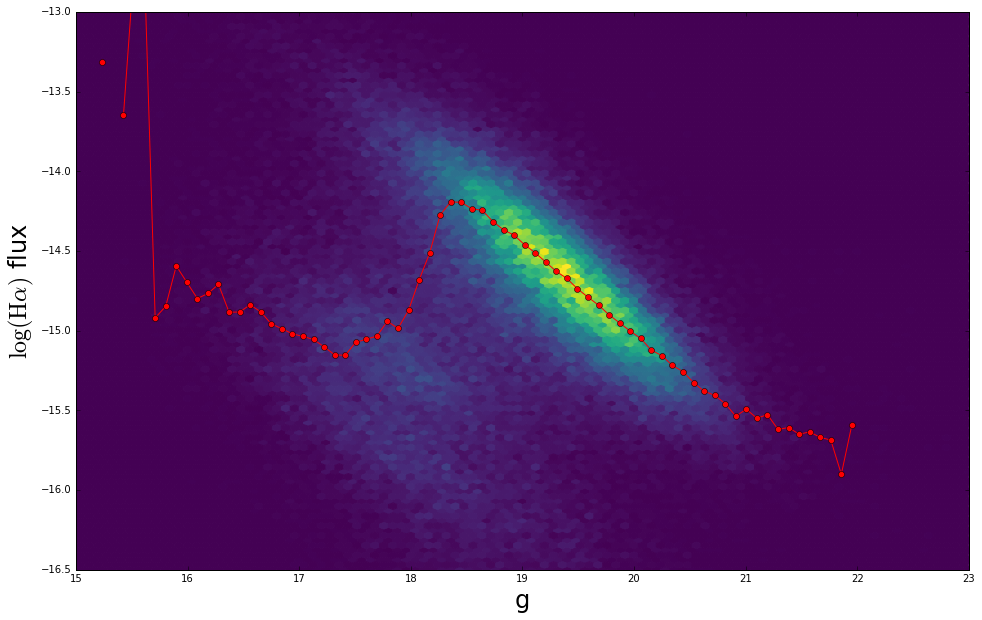

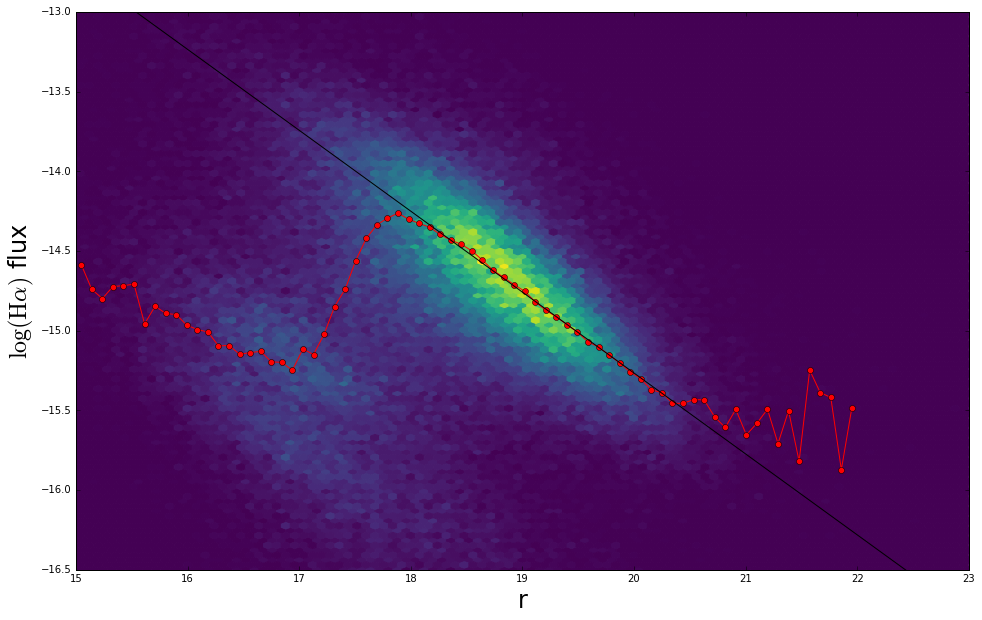

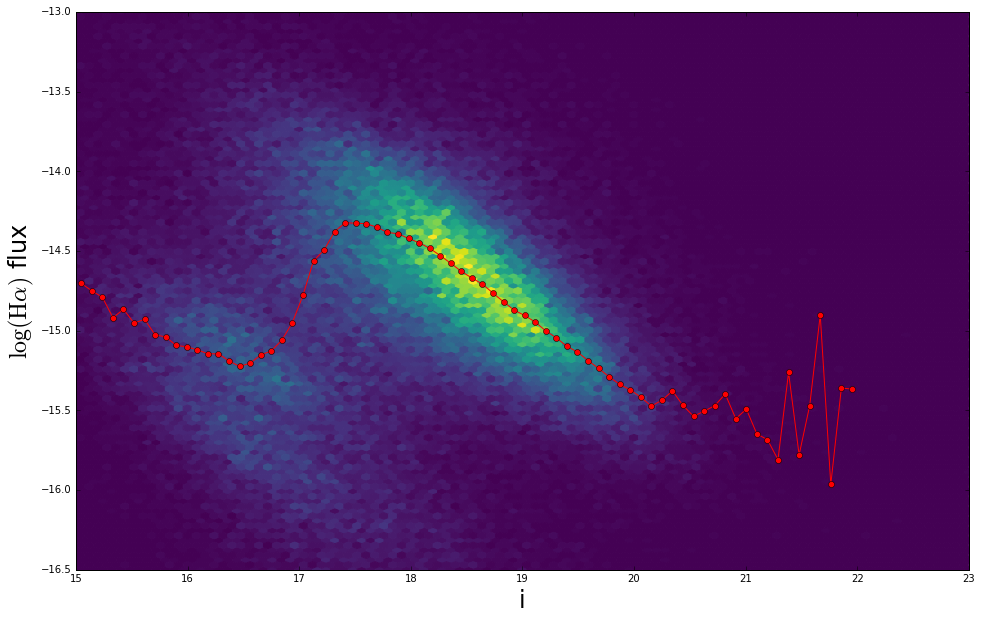

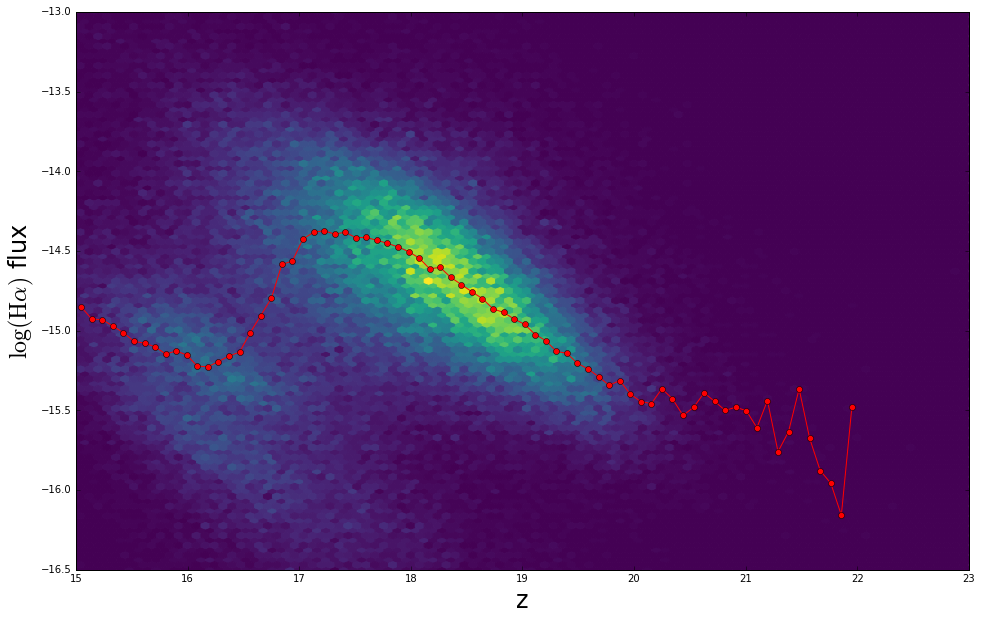

In [289]:
bandtocolor = {'u':'b', 'g':'g', 'r':'r', 'i':'m', 'z':'k'}

fibmag_to_lhaflux_interp = {}
lmods = {'u':modeling.models.Linear1D(slope=-0.75, intercept=0),
         'r':modeling.models.Linear1D(slope=-0.75, intercept=0)}
lmod_ranges = {'u': (20, 22), 'r':(18,20)}

fibmags = {}
for i, bandnm in enumerate('FNugriz'):
    if bandnm in 'FN':
        continue
    fibmags[bandnm] = fibmag = 22.5-2.5*np.log10(nsa['FIBERFLUX'][:, i])
    flux = nsa['HAFLUX']*10**-17*u.erg/u.s* u.cm**-2
    
    bins_for_med = np.linspace(15,22,75)
    meds = []
    for b1, b2 in zip(bins_for_med[:-1], bins_for_med[1:]):
        msk = (b1<fibmag)&(fibmag<b2)
        lflux = np.log10(flux.value)
        if np.sum(msk&np.isfinite(lflux)) == 0:
            meds.append(None)
            stds.append(None)
        else:
            scvals = sigma_clip(lflux[msk&np.isfinite(lflux)],sigma=2)
            meds.append(np.median(scvals.compressed()))
            
    meds = np.array(meds, dtype=float)
            
    bincens = (bins_for_med[1:]+bins_for_med[:-1])/2
    fibmag_to_lhaflux_interp[bandnm] = interpolate.interp1d(bincens[np.isfinite(meds)], 
                                                    meds[np.isfinite(meds)], 
                                                    kind='quadratic')
    
    plt.figure()

    plt.hexbin(fibmag, np.log10(flux.value), extent=(15,23,-16.5,-13))
    
    plt.plot(bincens, meds, '-or')
    
    if bandnm in lmods:
        if bandnm in lmod_ranges:
            msk = (lmod_ranges[bandnm][0]<bincens)&(bincens<lmod_ranges[bandnm][1])
        else:
            msk = np.ones(len(bincens), dtype=bool)
        newmod = modeling.fitting.LevMarLSQFitter()(lmods[bandnm], bincens[msk], meds[msk])
        lmods[bandnm] = newmod
        x = np.linspace(15, 23, 100)
        plt.plot(x, newmod(x),'k')
    
    #plt.scatter(fibmag, np.log10(flux.value), lw=0, alpha=.04, s=3, c=bandtocolor[bandnm])
    plt.xlim(15,23)
    plt.xlabel(bandnm, fontsize=24)
    plt.ylabel(r'$\log({\rm H}\alpha)$ flux', fontsize=24)
    plt.ylim(-16.5,-13)

Check that the two approaches give at least reasonably compatible-ish answers

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


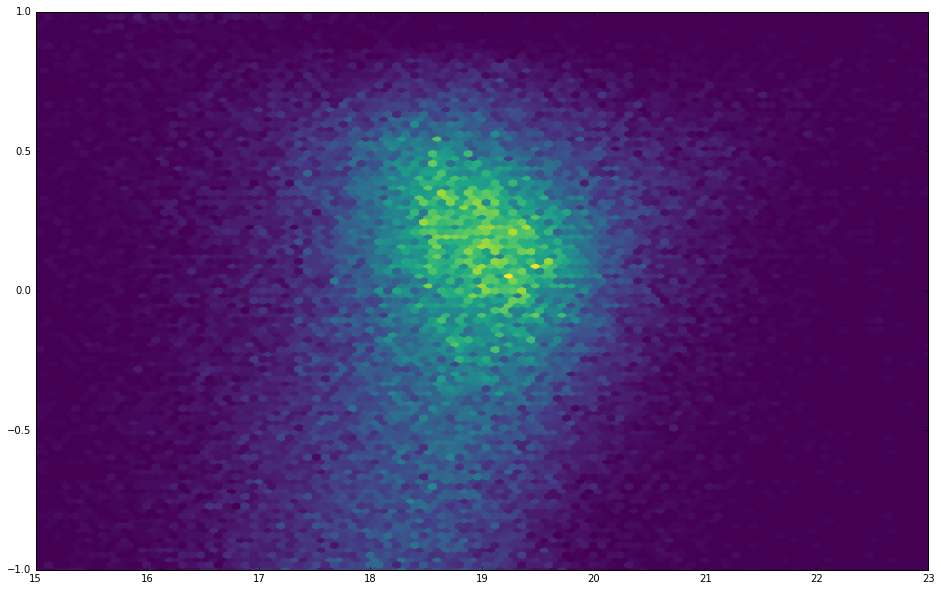

In [299]:
uflux = 10**lmods['u'](fibmags['u'])
rflux = 10**lmods['r'](fibmags['r'])

plt.hexbin(fibmags['r'], (uflux - rflux)/uflux, extent=(15, 23, -1, 1))

In [257]:
lmods

{'r': <Linear1D(slope=-0.5074828822006762, intercept=-5.115944337314049)>,
 'u': <Linear1D(slope=-0.544699254858693, intercept=-3.466572610994288)>}